**Question - 9**
--

Load the Fashion MNIST dataset; split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label. Note: for large images, you could use tf.io.encode_jpeg() instead. This would save a lot of space, but it would lose a bit of image quality.

In [1]:
from tensorflow.train import Int64List, BytesList, Feature, Features, Example
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

2024-07-24 20:23:39.348568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 20:23:39.348752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 20:23:39.499432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Loading the MNIST Dataset**

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
print(type(fashion_mnist))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
<class 'tuple'>


In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


**Creating the Validation Split**

In [4]:
X_valid, y_valid = X_train[:8000], y_train[:8000]
X_train, y_train = X_train[8000:], y_train[8000:]

for name, _ in [["X_train", X_train], ["y_train", y_train], 
                ["X_valid", X_valid], ["y_valid", y_valid], 
                ["X_test", X_test], ["y_test", y_test]]:
    print(name, _.shape)

X_train (52000, 28, 28)
y_train (52000,)
X_valid (8000, 28, 28)
y_valid (8000,)
X_test (10000, 28, 28)
y_test (10000,)


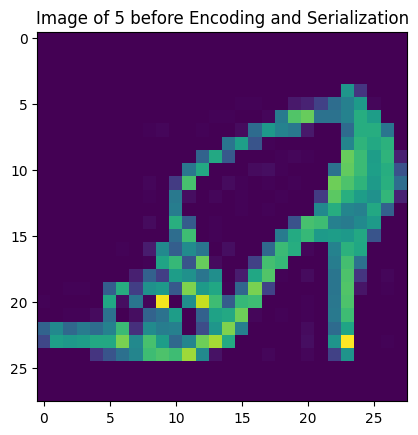

In [5]:
plt.imshow(X_train[0])
plt.title(f"Image of {y_train[0]} before Encoding and Serialization")
plt.show()

In [6]:
# Creating and Shuffling the TensorSlice Dataset used for training
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train), name="TrainingSet")
train_set = train_set.shuffle(10_000, seed=17)

valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid), name="ValidationSet")
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test), name="TestingSet")

**Saving the Dataset into multiple serialized TFRecord Files**

In [7]:
def serialize_instance(img, label):
    
    # Encoding the Image
    serialized_img = tf.io.serialize_tensor(img)
    
    # Returning as an Example Protocol Buffer
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[serialized_img.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))
            }
        )
    )

# Verification
for img, label in train_set.take(1):
    print(serialize_instance(img, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\002+:TX0\000\000\000\000\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\035\306\367\337\336\336\343\344\351\255\027\000\000\001\000\000\000\000\000\000\000\000\000\000\000\004\0007\353\353\271\260\312\314\320\332\317\357\3666\000\005\000\000\000\000\000\000\000\000\000\000\000\002\000\216\376\341\317\377\377\376\372\375\251\343\354H\000\002\001\000\000\000\000\000\000\000\000\000\001\000\000\251\334\342\210\306\304\307\344\377\233\342\244m\000\000\000\000\000\000\000\000\000\000\000\002\000\000~\311\344\353\345\273\343\335\374\371\254\260\244\265\236\027\000\002\000\000\000\000\000\000\000\000\000\236\307\255\265\336\365\364\347\356\375\253\301\251\225\200\235\202\000\001\000\000\000\000\000\000\000\000\014\307\265\267\262\255\303\350\351\335\277\265\254\234\211\204\205\236\010\000\

**Naive Approach**

In [8]:
def set_to_record(name, set_, n_parts=10):
    
    # Splitting the Indices into Chucks for storage as TFRecords
    indices = np.arange(len(set_))
    chunks = np.array_split(indices, n_parts) 
    
    # Creating the Storage Path
    storage_path = Path() / "naive"
    storage_path.mkdir(parents=True, exist_ok=True)
    
    # File name format for all the files
    file_format = "{}-set-{:02d}.tfrecord"
    
    compression_op = tf.io.TFRecordOptions(compression_type="GZIP")
    file_paths = []
    for idx, chunk in enumerate(chunks):
        file_path = str(storage_path / file_format.format(name, idx))
        file_paths.append(file_path)
        
        with tf.io.TFRecordWriter(file_path, compression_op) as tfrecord:
            for instance in chunk:
                serialized = serialize_instance(X_train[instance], y_train[instance])
                tfrecord.write(serialized.SerializeToString())
                tfrecord.write("\n")
    
    return file_paths

# Verification
ex_file_paths = set_to_record("Training", X_train)

# Used for testing the Indices from the np.array_split()
# for instance in chunk:
#     print("Instance: ", instance)
#     print("Len: ", len(chunk))
#     break 

**Loading and Parsing the TFRecords in Parallel**

Serialized Information before Parsing
tf.Tensor(b'\n\xc2\x06\n\xaf\x06\n\x05image\x12\xa5\x06\n\xa2\x06\n\x9f\x06\x08\x04\x12\x08\x12\x02\x08\x1c\x12\x02\x08\x1c"\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x85\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x02\x00\x00\x11\x181[o\x8a\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x02\x00\x00\x04j\xb9\xc3``q\x9e\x8d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x04\x00\x00\x02\x00\x00\x07Y\x88

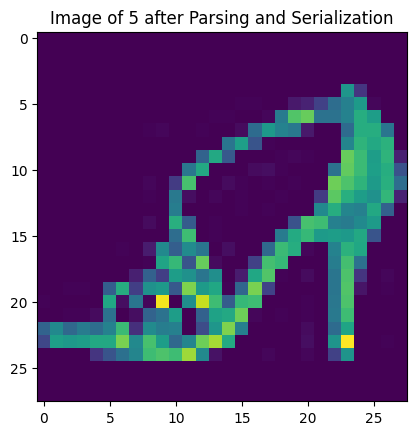

In [9]:
# Feature Description to Parse against the Serialized data in the protobuff
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
}

def parse_serialized_data(serialized_instance):
    # Step - 1: Remove the Serialization by Parsing the Feature Description
    encoded_image_data = tf.io.parse_single_example(serialized_instance, feature_description)
    
    # Step - 2: Decode the Encoded Image
    image_data = tf.io.parse_tensor(encoded_image_data["image"], out_type=tf.uint8)
    
    # Reshape and Return
    image = tf.reshape(image_data, shape=[28, 28])
    return image, encoded_image_data["label"]

# Verification
example_dataset = tf.data.TFRecordDataset(ex_file_paths[0], compression_type="GZIP")
instance = example_dataset.take(1)

print("Serialized Information before Parsing")
for i in instance:
    print(i)

print("\n\nSerialized Information after Parsing")
parsed_image = list(instance.map(parse_serialized_data))[0]
plt.imshow(parsed_image[0].numpy())
plt.title(f"Image of {parsed_image[1].numpy()} after Parsing and Serialization")
plt.show()

In [10]:
def create_interleaved_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, 
                               n_parse_threads=5, batch_size=32, cache=False):
    
    # Creating the TFRecord Dataset containing Serialized Information
    serialized_dataset = tf.data.TFRecordDataset(
        filepaths, num_parallel_reads=n_read_threads, compression_type="GZIP"
    )
    
    # Caching the Data for better Efficiency
    if cache:
        serialized_dataset = serialized_dataset.cache()
        
    # Shuffling the Data
    if shuffle_buffer_size:
        serialized_dataset = serialized_dataset.shuffle(shuffle_buffer_size)
        
    # Parsing all the Serialzed Instances of the Dataset in Parallel
    dataset = serialized_dataset.map(parse_serialized_data, num_parallel_calls=n_parse_threads)
        
    '''# Batching and Prefetching
    dataset = dataset.batch(batch_size)
    for i in dataset.take(2):
        print(i)
        
    return dataset.prefetch(1)'''

create_interleaved_dataset(ex_file_paths)
# Verification
# dataset = create_interleaved_dataset(filepaths=ex_file_paths, shuffle_buffer_size=10_000)
# for i in dataset.take(2):
#     print(i)

In [11]:
# Creating and Shuffling the TensorSlice Dataset used for training
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train), name="TrainingSet")
train_set = train_set.shuffle(10_000, seed=17)

valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid), name="ValidationSet")
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test), name="TestingSet")